# Conduct Backtest

In [72]:
import sys
import os
sys.path.append(os.path.abspath("D:\\Python\\commodity_futures_price"))

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
from model.savvy_sh import SavvySh

In [73]:
data = pd.read_csv('../../data/processed_stock/cleaned_AAPL.csv', index_col=0, parse_dates=True).dropna()
raw_y = data["Close"]
raw_X = data[["MOM_vol_adj", "Skewness", "Volatility", "Op_Int", "Value_BM"]]

In [75]:
y = raw_y.pct_change().shift(-1).dropna()
X = raw_X.iloc[:-1]

### Standardized

In [105]:
strategies = ["OLS", "Stein", "DSh", "Sh", "SR", "GSR", "LSh", "SRR"]
wealth_dict = {strat: [10000] for strat in strategies}
shares_dict = {strat: [0] for strat in strategies}
hit_dict = {strat: 0 for strat in strategies}

train_size = 252 # three month
threshold = 0.001 # threshold for significant signal strength; should be optimized
k = 1 # sensitivity to the prediction; should be optimized

for start in range(len(X) - train_size - 2):
    for strat in strategies:
        train_X, train_y = X.iloc[start:start + train_size + 1], y.iloc[start:start + train_size + 1]
        test_X, test_y = X.iloc[start + train_size + 1:start + train_size + 2], y.iloc[start + train_size + 1:start + train_size + 2]
        
        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)

        if strat == "OLS":
            ols = LinearRegression()
            ols.fit(train_X, train_y)
            predict = ols.predict(test_X)
        elif strat == "LSh":
            model_linear = SavvySh(model_class="Linear")
            model_linear.fit(train_X, train_y)
            predict = model_linear.predict(test_X)["LSh"]
        elif strat == "SRR":
            model_shrinkage_ridge = SavvySh(model_class="ShrinkageRR")
            model_shrinkage_ridge.fit(train_X, train_y)
            predict = model_shrinkage_ridge.predict(test_X)["SRR"]
        elif strat in ["SR", "GSR"]:
            model_slab = SavvySh(model_class="Slab")
            model_slab.fit(train_X, train_y)
            tmp_pred = model_slab.predict(test_X)
            if strat == "SR":
                predict = tmp_pred["SR"]
            else:
                predict = tmp_pred["GSR"]
        else:
            model_mult = SavvySh(model_class="Multiplicative", include_Sh=True)
            model_mult.fit(train_X, train_y)
            tmp_pred = model_mult.predict(test_X)
            if strat == "Stein":
                predict = tmp_pred["St"]
            elif strat == "DSh":
                predict = tmp_pred["DSh"]
            else:
                predict = tmp_pred["Sh"]
        predict = predict[0]
        # Use sigma to normalize the prediction
        sigma = np.std(train_y[-63:])
        W = predict / sigma
        # Assume that the max/min weight would be +1/-1
        W = np.tanh(k * W) if abs(W) > threshold else None

        last_wealth = wealth_dict[strat][-1]
        last_shares = shares_dict[strat][-1]

        p_t = raw_y.iloc[start + train_size]
        p_t1 = raw_y.iloc[start + train_size + 1]

        curr_wealth = last_wealth + last_shares * (p_t1 - p_t)
        wealth_dict[strat].append(curr_wealth)
        curr_shares = last_shares
        if W is not None:
            curr_shares = int(last_wealth * W / p_t1)
        shares_dict[strat].append(curr_shares)

        # print(test_y.iloc[0], predict)
        if test_y.iloc[0] * predict > 0:
            hit_dict[strat] += 1

for strat in strategies:
    hit_dict[strat] = hit_dict[strat] / (len(X) - train_size - 2)
print(hit_dict)

{'OLS': 0.4988733663812528, 'Stein': 0.4988733663812528, 'DSh': 0.48986029743127535, 'Sh': 0.49842271293375395, 'SR': 0.49436683190626407, 'GSR': 0.47273546642631814, 'LSh': 0.4785939612438035, 'SRR': 0.49842271293375395}


In [107]:
for strat in strategies:
    print("Strategy:", strat)
    print("Final Wealth:", wealth_dict[strat][-1])

Strategy: OLS
Final Wealth: 6035.941690444947
Strategy: Stein
Final Wealth: 7067.62021827698
Strategy: DSh
Final Wealth: 6363.372739791869
Strategy: Sh
Final Wealth: 9988.59338760376
Strategy: SR
Final Wealth: 6166.731096267701
Strategy: GSR
Final Wealth: 3117.834430694569
Strategy: LSh
Final Wealth: 5244.995712280274
Strategy: SRR
Final Wealth: 6030.071458816529


### Non-standardized

In [104]:
strategies = ["OLS", "Stein", "DSh", "Sh", "SR", "GSR", "LSh", "SRR"]
nonstd_wealth_dict = {strat: [10000] for strat in strategies}
nonstd_shares_dict = {strat: [0] for strat in strategies}
nonstd_hit_dict = {strat: 0 for strat in strategies}

train_size = 252 # three month
threshold = 0.001 # threshold for significant signal strength; should be optimized
k = 1 # sensitivity to the prediction; should be optimized

for start in range(len(X) - train_size - 2):
    for strat in strategies:
        train_X, train_y = X.iloc[start:start + train_size + 1], y.iloc[start:start + train_size + 1]
        test_X, test_y = X.iloc[start + train_size + 1:start + train_size + 2], y.iloc[start + train_size + 1:start + train_size + 2]

        if strat == "OLS":
            ols = LinearRegression()
            ols.fit(train_X, train_y)
            predict = ols.predict(test_X)
        elif strat == "LSh":
            model_linear = SavvySh(model_class="Linear")
            model_linear.fit(train_X, train_y)
            predict = model_linear.predict(test_X)["LSh"]
        elif strat == "SRR":
            model_shrinkage_ridge = SavvySh(model_class="ShrinkageRR")
            model_shrinkage_ridge.fit(train_X, train_y)
            predict = model_shrinkage_ridge.predict(test_X)["SRR"]
        elif strat in ["SR", "GSR"]:
            model_slab = SavvySh(model_class="Slab")
            model_slab.fit(train_X, train_y)
            tmp_pred = model_slab.predict(test_X)
            if strat == "SR":
                predict = tmp_pred["SR"]
            else:
                predict = tmp_pred["GSR"]
        else:
            model_mult = SavvySh(model_class="Multiplicative", include_Sh=True)
            model_mult.fit(train_X, train_y)
            tmp_pred = model_mult.predict(test_X)
            if strat == "Stein":
                predict = tmp_pred["St"]
            elif strat == "DSh":
                predict = tmp_pred["DSh"]
            else:
                predict = tmp_pred["Sh"]
        predict = predict[0]
        # Use sigma to normalize the prediction
        sigma = np.std(train_y[-63:])
        W = predict / sigma
        # Assume that the max/min weight would be +1/-1
        W = np.tanh(k * W) if abs(W) > threshold else None

        last_wealth = nonstd_wealth_dict[strat][-1]
        last_shares = nonstd_shares_dict[strat][-1]

        p_t = raw_y.iloc[start + train_size]
        p_t1 = raw_y.iloc[start + train_size + 1]

        curr_wealth = last_wealth + last_shares * (p_t1 - p_t)
        nonstd_wealth_dict[strat].append(curr_wealth)
        curr_shares = last_shares
        if W is not None:
            curr_shares = int(last_wealth * W / p_t1)
        nonstd_shares_dict[strat].append(curr_shares)

        # print(test_y.iloc[0], predict)
        if test_y.iloc[0] * predict > 0:
            nonstd_hit_dict[strat] += 1

for strat in strategies:
    nonstd_hit_dict[strat] = nonstd_hit_dict[strat] / (len(X) - train_size - 2)
print(nonstd_hit_dict)

{'OLS': 0.4988733663812528, 'Stein': 0.4988733663812528, 'DSh': 0.49391617845876523, 'Sh': 0.5074357818837314, 'SR': 0.4988733663812528, 'GSR': 0.4758900405588103, 'LSh': 0.5299684542586751, 'SRR': 0.5105903560162235}


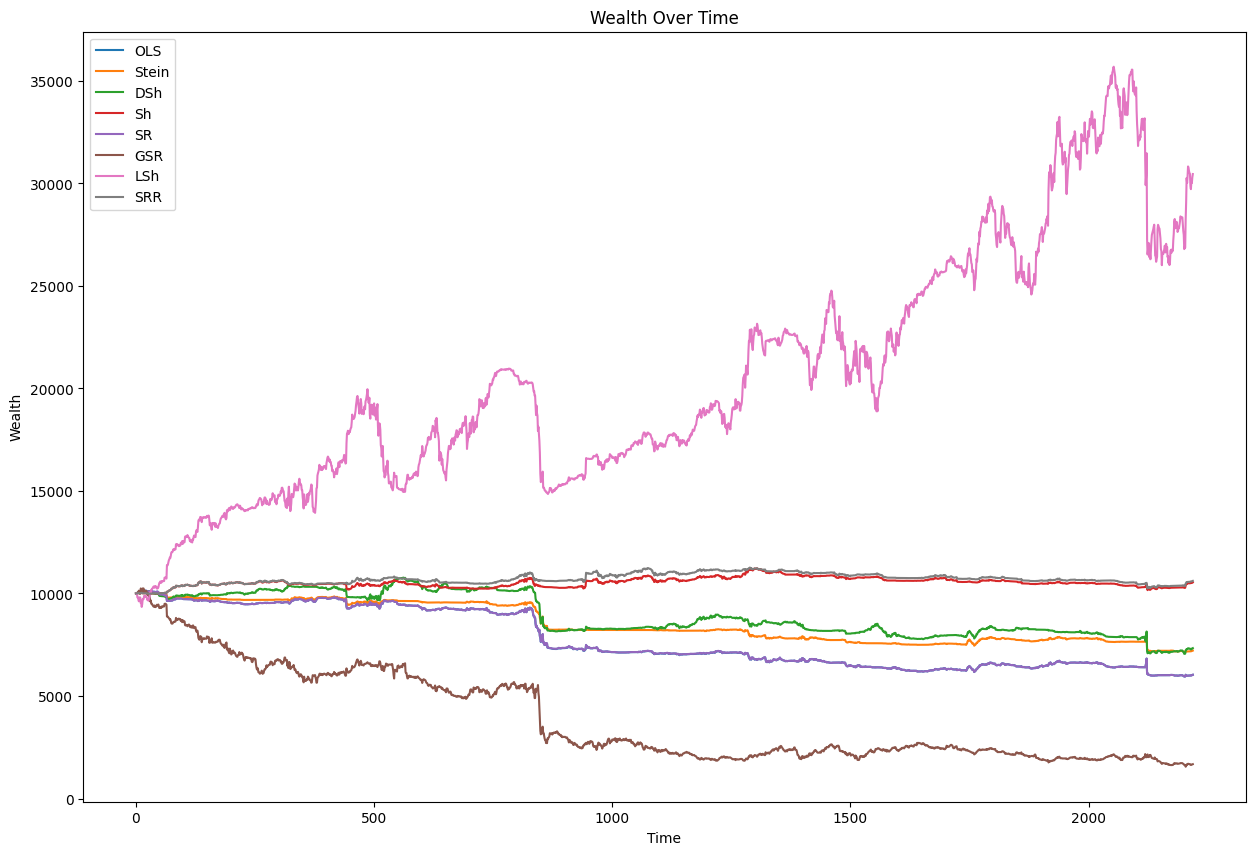

In [110]:
# Plot the wealth
plt.figure(figsize=(15, 10))
for strat in strategies:
    plt.plot(nonstd_wealth_dict[strat], label=strat)
plt.title("Wealth Over Time")
plt.xlabel("Time")
plt.ylabel("Wealth")
plt.legend()
plt.show()